In [1]:

# Set up notebook
%pprint
import sys
if (osp.join(os.pardir, 'py') not in sys.path): sys.path.insert(1, osp.join(os.pardir, 'py'))

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import (fu, nu, DataFrame, Series, concat, nan, re, display)
from datetime import date, timedelta
import os
from IPython.display import HTML
import pandas as pd


# DARPA ITM Medical Triage Paper

> Once we finalize all complete records for the registry (or identify the subset for analyses), based on our slack discussion, we'll need to redo some of the analyses for the paper. I made a listing below of what I think we need for the article and based on the feedback that I've received so far.

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='',
    first_responder_master_registry_scene_stats_df='', count_swaps_df='',
    verbose=False
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
print('triage_paper_df', triage_paper_df.shape[0], triage_paper_df.session_uuid.nunique(), triage_paper_df.shape[1]) # 401177 332 111
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
print('file_stats_df', file_stats_df.shape[0], file_stats_df.file_name.nunique(), file_stats_df.shape[1]) # 332 332 19
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']
print('scene_stats_df', scene_stats_df.shape[0], scene_stats_df.session_uuid.nunique(), scene_stats_df.shape[1]) # 486 332 48
count_swaps_df = data_frames_dict['count_swaps_df']
print('count_swaps_df', count_swaps_df.shape[0], count_swaps_df.session_uuid.nunique(), count_swaps_df.shape[1]) # 331 331 3

triage_paper_df 401177 332 111
file_stats_df 332 332 19
scene_stats_df 486 332 48
count_swaps_df 331 331 3


In [4]:

if 'scene_id' in triage_paper_df.columns:
    df = triage_paper_df.merge(count_swaps_df, on=fu.scene_groupby_columns, how='inner')
    print('triage_paper_df', df.shape[0], df.session_uuid.nunique(), df.shape[1]) # 397230 331 112
if 'scene_id' in file_stats_df.columns:
    df = file_stats_df.merge(count_swaps_df, on=fu.scene_groupby_columns, how='inner')
    print('file_stats_df', df.shape[0], df.session_uuid.nunique(), df.shape[1])
if 'scene_id' in scene_stats_df.columns:
    df = scene_stats_df.merge(count_swaps_df, on=fu.scene_groupby_columns, how='inner')
    print('scene_stats_df', df.shape[0], df.session_uuid.nunique(), df.shape[1]) # 331 331 49

triage_paper_df 397230 331 112
scene_stats_df 331 331 49


In [5]:

# Merge only count swaps scenes
patient_count_filter_fn = lambda scene_df: True
elevens_df = fu.get_elevens_dataframe(
    triage_paper_df.merge(count_swaps_df, on=fu.scene_groupby_columns, how='inner'),
    file_stats_df,
    scene_stats_df.merge(count_swaps_df, on=fu.scene_groupby_columns, how='inner'),
    needed_columns=['scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'overall_category'],
    patient_count_filter_fn=patient_count_filter_fn
)
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 397230 331 117

elevens_df 397230 331 118


In [6]:

# Get a dataset of only first11 patients
nongrouped_patients_list = nu.load_object('nongrouped_patients_list')
mask_series = ~elevens_df.patient_id.isin(nongrouped_patients_list)
elevens_df = elevens_df[mask_series]
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 388745 331 117

elevens_df 388745 331 118


In [7]:

# for the "Other" label, instead, put back whether they were Faculty or something else (Nurse, etc.)
mask_series = (elevens_df.responder_category == 'Other')
elevens_df.loc[mask_series, 'responder_category'] = elevens_df.loc[mask_series, 'overall_category']


## Triage efficiency (mean, SD, median, IQR) by each responder type


* **Time to triage scene**

In [8]:

# Get whisker plot for Time to triage scene
import seaborn as sns
import matplotlib.pyplot as plt

temporalize_fn = lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='minutes')
def show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df, print_responder_counts=False, verbose=False):
    x_column_name = 'responder_category'
    x_label = ' '.join([w.title() for w in x_column_name.split('_')])
    responder_categories_list = ['EMT-Basic', 'Paramedic', 'Medical Student', 'EM Resident']
    responder_categories_dict = {o: n for o, n in zip(
        responder_categories_list, ['EMT-Basic', 'EMT-Paramedic', 'Medical Student', 'EM-Resident']
    )}
    rows_list = []
    for responder_category in responder_categories_list:
        mask_series = (logs_df[x_column_name] == responder_category)
        responder_categories_df = logs_df[mask_series]
        if verbose: print('session_uuid in responder_categories_df:', bool('session_uuid' in responder_categories_df.columns))
        gb = responder_categories_df.groupby(fu.scene_groupby_columns)
        for (session_uuid, scene_id), scene_df in gb:
            if verbose: print('session_uuid in scene_df:', bool('session_uuid' in scene_df.columns))
            row_dict = {}
            if 'session_uuid' in scene_df.columns: row_dict['session_uuid'] = session_uuid
            if 'scene_id' in scene_df.columns: row_dict['scene_id'] = scene_id
            row_dict[x_column_name] = responder_category
            row_dict[y_column_name] = scene_fn(scene_df)
            row_dict['scene_count'] = gb.size().shape[0]
            rows_list.append(row_dict)
    df = DataFrame(rows_list)

    # Create a figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    # Create a box plot of the y column grouped by the x column
    ax = sns.boxplot(
        x=x_column_name,
        y=y_column_name,
        showmeans=True,
        data=df,
        ax=ax
    )

    # Rotate the x-axis labels to prevent overlapping
    plt.xticks(rotation=45)

    # Label the x- and y-axis
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Humanize y tick labels
    locs, labels = plt.yticks()
    yticklabels_list = []
    for ytick_value, text_obj in zip(locs, labels):
        text_obj.set_text(
            ytick_fn(ytick_value)
        )
        yticklabels_list.append(text_obj)
    plt.yticks(locs[1:], yticklabels_list[1:])

    # Re-label x tick labels
    locs, labels = plt.xticks()
    xticklabels_list = []
    for idx, text_obj in zip(locs, labels):
        text_obj.set_text(responder_categories_dict[responder_categories_list[idx]])
        xticklabels_list.append(text_obj)
    plt.xticks(locs, xticklabels_list)

    plt.show()
    
    if print_responder_counts:
        for responder_category, xlabel in zip(responder_categories_list, [text_obj.get_text() for text_obj in labels]):
            mask_series = (df[x_column_name] == responder_category)
            scene_count = df[mask_series].scene_count.tolist()[0]
            print(f'{xlabel}: {scene_count} responders')

In [9]:

# Get info for Time to triage scene
from datetime import timedelta

cn = 'triage_time'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    df = Series(
        [fu.get_triage_time(scene_df) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
    ).to_frame().rename(columns={0: cn})
    df = nu.get_statistics(df, [cn]).applymap(temporalize_fn, na_action='ignore')
    statistics_df = concat([statistics_df, df.rename(columns={cn: responder_category}).T], axis='index')
    ttts_dict = df.to_dict()[cn]
    print(
        f"{responder_category}: {ttts_dict['mean']} (SD = {ttts_dict['SD']}, Median = {ttts_dict['median']},"
        f" IQR = ({ttts_dict['25%']}, {ttts_dict['75%']}))"
    )

# Display it as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'] + ', ' + statistics_df['75%'] + ')'
columns_list = ['Mean Time to Triage Scene', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[2]})[columns_list].to_html())

EM Resident: 8:34 (SD = 1:45, Median = 8:22, IQR = (7:34, 9:07))
EM-Faculty: 10:40 (SD = 4:12, Median = 9:53, IQR = (7:16, 13:18))
EMT-Basic: 8:16 (SD = 2:09, Median = 7:41, IQR = (6:47, 9:36))
Medical Student: 8:40 (SD = 2:13, Median = 8:46, IQR = (7:28, 10:12))
Nurse: 7:24 (SD = nan, Median = 7:24, IQR = (7:24, 7:24))
Other HP: 8:23 (SD = nan, Median = 8:23, IQR = (8:23, 8:23))
Paramedic: 7:34 (SD = 1:49, Median = 7:21, IQR = (6:14, 8:33))



,Mean Time to Triage Scene,SD,Median,IQR
EM Resident,8:34,1:45,8:22,"(7:34, 9:07)"
EM-Faculty,10:40,4:12,9:53,"(7:16, 13:18)"
EMT-Basic,8:16,2:09,7:41,"(6:47, 9:36)"
Medical Student,8:40,2:13,8:46,"(7:28, 10:12)"
Nurse,7:24,NaN,7:24,"(7:24, 7:24)"
Other HP,8:23,NaN,8:23,"(8:23, 8:23)"
Paramedic,7:34,1:49,7:21,"(6:14, 8:33)"


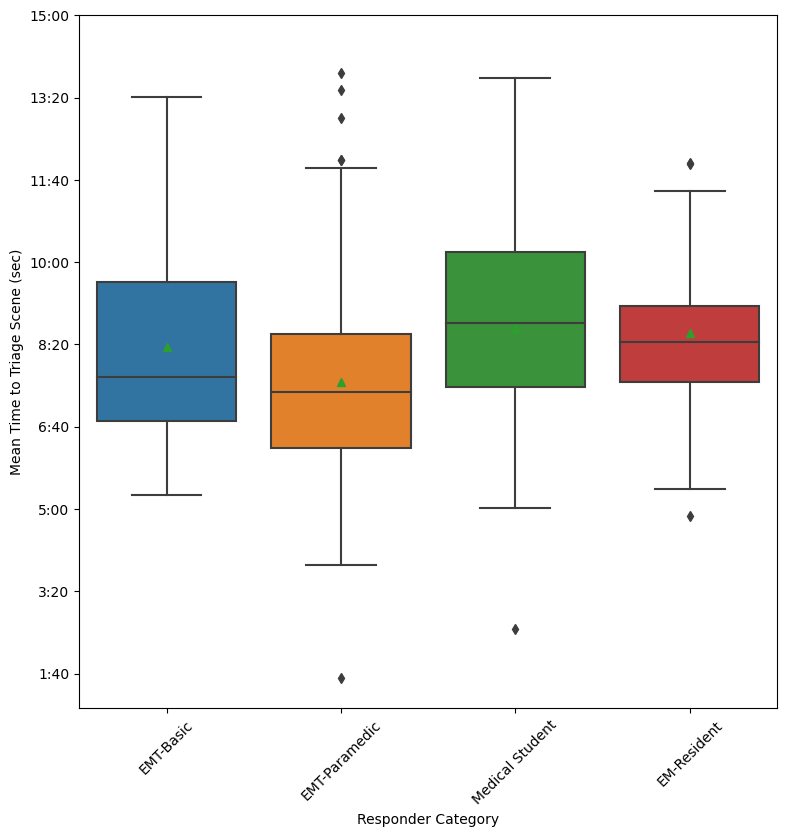

In [10]:

y_column_name = 'triage_time'
y_label = 'Mean Time to Triage Scene (sec)'
scene_fn = lambda scene_df: fu.get_triage_time(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df, verbose=False)


* **Hemorrhage Control for all Life-threatening Bleeding (and percentage of participants who implemented all required hemorrhage control)**

In [11]:

# Get info for Hemorrhage control for all life-threatening bleeding percentage
cn = 'last_controlled_time'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    df = Series(
        [fu.get_time_to_last_hemorrhage_controlled(scene_df) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
    ).to_frame().rename(columns={0: cn})
    df = nu.get_statistics(df, [cn]).applymap(lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='minutes'), na_action='ignore')
    hcfaltb_dict = df.to_dict()[cn]
    df = df.rename(columns={cn: responder_category}).T
    phc = int(Series(
        [fu.get_percent_hemorrhage_controlled(scene_df, verbose=False) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
    ).mean())
    df['phc'] = phc
    statistics_df = concat([statistics_df, df], axis='index')
    print(
        f"{responder_category}: {hcfaltb_dict['mean']} at {phc}% (SD = {hcfaltb_dict['SD']}, Median = {hcfaltb_dict['median']},"
        f" IQR = ({hcfaltb_dict['25%']}, {hcfaltb_dict['75%']}))"
    )

# Display it as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'] + ', ' + statistics_df['75%'] + ')'
columns_list = ['Mean Time to Hemorrhage Control', '%', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[3], 'phc':  columns_list[1]})[columns_list].to_html())

EM Resident: 6:43 at 86% (SD = 1:50, Median = 6:33, IQR = (5:22, 7:31))
EM-Faculty: 8:12 at 100% (SD = 3:41, Median = 8:00, IQR = (5:24, 10:48))
EMT-Basic: 4:11 at 95% (SD = 2:51, Median = 4:06, IQR = (2:58, 4:53))
Medical Student: 5:34 at 84% (SD = 2:34, Median = 5:46, IQR = (4:32, 7:16))
Nurse: 3:55 at 100% (SD = nan, Median = 3:55, IQR = (3:55, 3:55))
Other HP: 6:43 at 100% (SD = nan, Median = 6:43, IQR = (6:43, 6:43))
Paramedic: 4:21 at 96% (SD = 2:18, Median = 4:43, IQR = (3:34, 5:36))



,Mean Time to Hemorrhage Control,%,SD,Median,IQR
EM Resident,6:43,86,1:50,6:33,"(5:22, 7:31)"
EM-Faculty,8:12,100,3:41,8:00,"(5:24, 10:48)"
EMT-Basic,4:11,95,2:51,4:06,"(2:58, 4:53)"
Medical Student,5:34,84,2:34,5:46,"(4:32, 7:16)"
Nurse,3:55,100,NaN,3:55,"(3:55, 3:55)"
Other HP,6:43,100,NaN,6:43,"(6:43, 6:43)"
Paramedic,4:21,96,2:18,4:43,"(3:34, 5:36)"


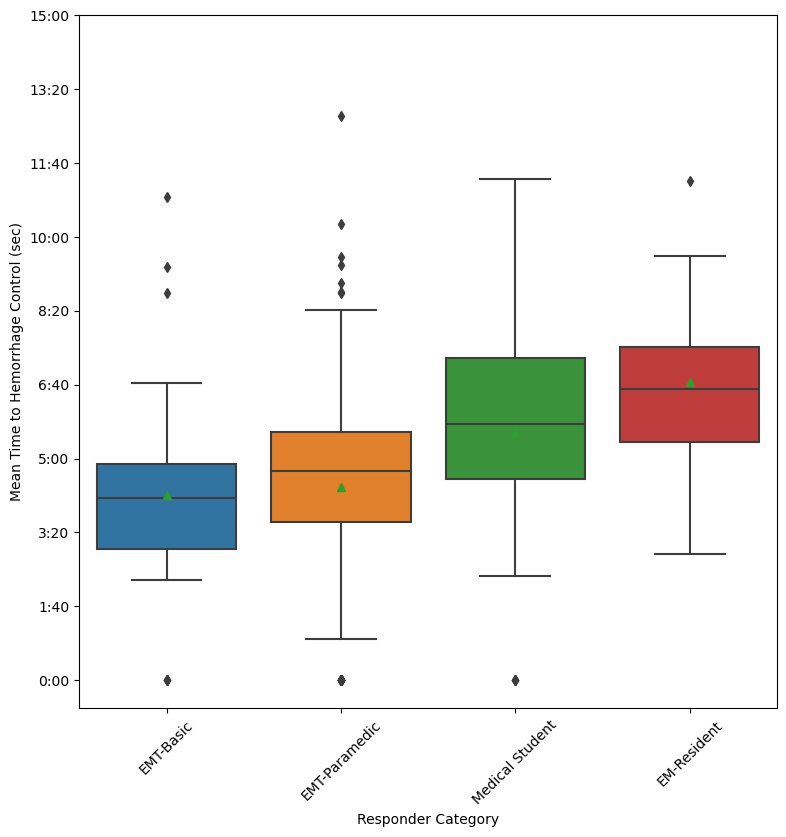

In [12]:

y_column_name = 'time_to_last_hemorrhage_controlled'
y_label = 'Mean Time to Hemorrhage Control (sec)'
scene_fn = lambda scene_df: fu.get_time_to_last_hemorrhage_controlled(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn)


* **Hemorrhage Control per Patient**

In [13]:

# Get info for Hemorrhage control per patient
# Duration of time from when the patient was first approached by the participant until
# the time hemorrhage treatment was applied (with a tourniquet or wound packing)
cn = 'controlled_time'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    times_list = []
    for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns):
        # scene_start = fu.get_scene_start(scene_df)
        for _, patient_df in scene_df.groupby('patient_id'):
            if fu.get_is_patient_hemorrhaging(patient_df):
                controlled_time = fu.get_time_to_hemorrhage_control(patient_df, scene_start=fu.get_first_patient_interaction(patient_df))
                times_list.append(controlled_time)
    df = Series(times_list).to_frame().rename(columns={0: cn})
    df = nu.get_statistics(df, [cn]).applymap(
        lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='seconds'), na_action='ignore'
    )
    statistics_df = concat([statistics_df, df.rename(columns={cn: responder_category}).T], axis='index')
    hcpp_dict = df.to_dict()[cn]
    print(
        f"{responder_category}: {hcpp_dict['mean']} (SD = {hcpp_dict['SD']}, Median = {hcpp_dict['median']},"
        f" IQR = ({hcpp_dict['25%']}, {hcpp_dict['75%']}))"
    )

# Display it as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'] + ', ' + statistics_df['75%'] + ')'
columns_list = ['Mean Time for Hemorrhage control per Patient', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[2]})[columns_list].to_html())

EM Resident: 39 sec (SD = 1:17, Median = 12 sec, IQR = (3 sec, 31 sec))
EM-Faculty: 38 sec (SD = 1:06, Median = 14 sec, IQR = (8 sec, 25 sec))
EMT-Basic: 10 sec (SD = 15 sec, Median = 7 sec, IQR = (2 sec, 13 sec))
Medical Student: 37 sec (SD = 1:17, Median = 11 sec, IQR = (4 sec, 23 sec))
Nurse: 11 sec (SD = 8 sec, Median = 10 sec, IQR = (8 sec, 13 sec))
Other HP: 11 sec (SD = 11 sec, Median = 5 sec, IQR = (4 sec, 21 sec))
Paramedic: 15 sec (SD = 34 sec, Median = 8 sec, IQR = (2 sec, 14 sec))



,Mean Time for Hemorrhage control per Patient,SD,Median,IQR
EM Resident,39 sec,1:17,12 sec,"(3 sec, 31 sec)"
EM-Faculty,38 sec,1:06,14 sec,"(8 sec, 25 sec)"
EMT-Basic,10 sec,15 sec,7 sec,"(2 sec, 13 sec)"
Medical Student,37 sec,1:17,11 sec,"(4 sec, 23 sec)"
Nurse,11 sec,8 sec,10 sec,"(8 sec, 13 sec)"
Other HP,11 sec,11 sec,5 sec,"(4 sec, 21 sec)"
Paramedic,15 sec,34 sec,8 sec,"(2 sec, 14 sec)"


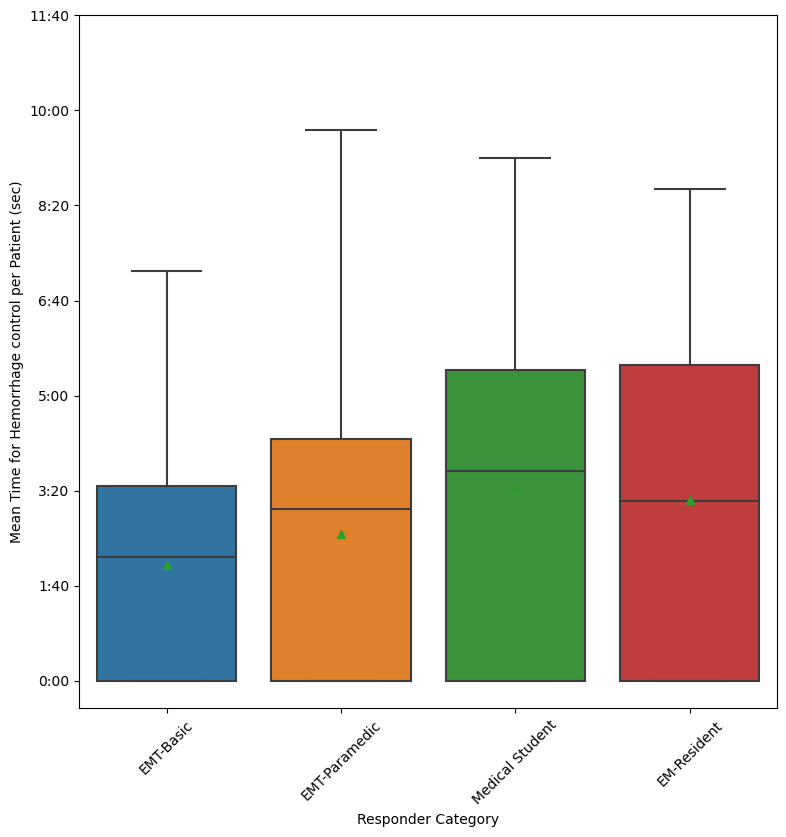

In [14]:

# Duration of time from when the patient was first approached by the participant until
# the time hemorrhage treatment was applied (with a tourniquet or wound packing)
y_column_name = 'time_to_hemorrhage_control'
y_label = 'Time to Hemorrhage control per Patient (sec)'
scene_fn = lambda scene_df: fu.get_time_to_hemorrhage_control_per_patient(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn)


## Triage accuracy (mean, SD, median, IQR) by each responder type (to keep things simple let's not break this out by individual tag category as we had it, but by overall rates for each responder type)

In [ ]:

# Create the tag-to-SALT data frame
tag_to_salt_df = fu.get_is_tag_correct_dataframe(elevens_df, groupby_column='responder_category')

In [ ]:

# Get the percentage tag correct counts for each scene for each group
correct_count_by_tag_df = fu.get_percentage_tag_correct_dataframe(tag_to_salt_df, groupby_column='responder_category')


* **triage tag accuracy**

In [17]:

# Get info for triage tag accuracy
cn = 'percentage_tag_correct'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in correct_count_by_tag_df.groupby('responder_category'):
    mask_series = responder_categories_df.predicted_tag.isin(fu.tag_color_order[:-1])
    df = responder_categories_df[mask_series]
    df = nu.get_statistics(df, [cn])
    statistics_df = concat([statistics_df, df.rename(columns={cn: responder_category}).T], axis='index')
    tta_dict = df.to_dict()[cn]
    print(
        f"{responder_category}: accurately tagged {tta_dict['mean']:.1f}% of patients"
        f" (SD = {tta_dict['SD']:.1f}, Median = {tta_dict['median']},"
        f" IQR = ({tta_dict['25%']:.1f}, {tta_dict['75%']}))"
    )

# Display as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'].map(lambda x: str(round(x, 1))) + ', ' + statistics_df['75%'].map(lambda x: str(x)) + ')'
for cn in ['mean', 'SD']: statistics_df[cn] = statistics_df[cn].map(lambda x: str(round(x, 1)))
columns_list = ['Mean % Accurately Tagged', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[2]})[columns_list].to_html())

EM Resident: accurately tagged 72.4% of patients (SD = 36.2, Median = 100.0, IQR = (50.0, 100.0))
EM-Faculty: accurately tagged 78.3% of patients (SD = 33.3, Median = 100.0, IQR = (62.5, 100.0))
EMT-Basic: accurately tagged 83.8% of patients (SD = 29.1, Median = 100.0, IQR = (75.0, 100.0))
Medical Student: accurately tagged 68.2% of patients (SD = 39.5, Median = 100.0, IQR = (50.0, 100.0))
Nurse: accurately tagged 90.0% of patients (SD = 22.4, Median = 100.0, IQR = (100.0, 100.0))
Other HP: accurately tagged 85.0% of patients (SD = 22.4, Median = 100.0, IQR = (75.0, 100.0))
Paramedic: accurately tagged 79.1% of patients (SD = 33.9, Median = 100.0, IQR = (50.0, 100.0))



,Mean % Accurately Tagged,SD,Median,IQR
EM Resident,72.4,36.2,100.0,"(50.0, 100.0)"
EM-Faculty,78.3,33.3,100.0,"(62.5, 100.0)"
EMT-Basic,83.8,29.1,100.0,"(75.0, 100.0)"
Medical Student,68.2,39.5,100.0,"(50.0, 100.0)"
Nurse,90.0,22.4,100.0,"(100.0, 100.0)"
Other HP,85.0,22.4,100.0,"(75.0, 100.0)"
Paramedic,79.1,33.9,100.0,"(50.0, 100.0)"


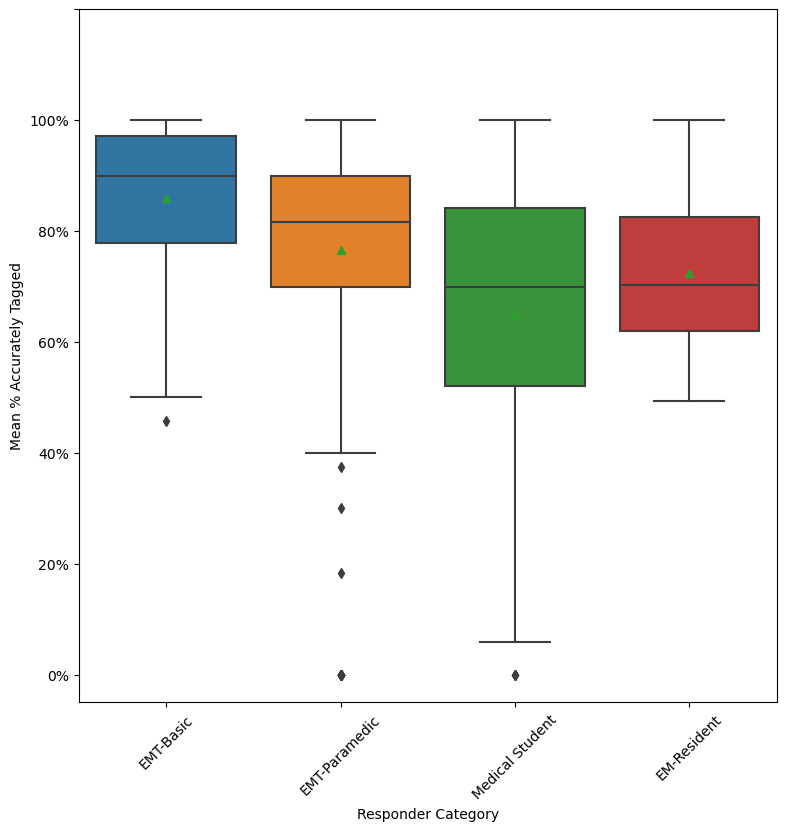

In [18]:

y_column_name = 'percentage_tag_correct'
y_label = 'Mean % Accurately Tagged'
scene_fn = lambda scene_df: scene_df[y_column_name].mean()
percents_fn = lambda x: f'{int(x)}%' if (x<=100) else ''
show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=percents_fn, logs_df=correct_count_by_tag_df)


To do formal comparisons we need to run statistics like ANOVA and t-tests. We'll need the values for each measure per responder. Something like this below:
<table>
    <tr><th>ID</th><th>Group</th><th>TTS</th><th>THC</th><th>THCP</th><th>Tag Accuracy</th></tr>
    <tr><td>Responder 1</td><td>EM Resident</td><td>8:20</td><td>6:10</td><td>25</td><td>81</td></tr>
    <tr><td>Responder 2</td><td>EMT-Basic</td><td>8:05</td><td>5:02</td><td>15</td><td>75</td></tr>
    <tr><td>Responder 3</td><td>Paramedic</td><td>7:40</td><td>4:30</td><td>18</td><td>78</td></tr>
</table>
etc.

In [19]:

if nu.csv_exists('anova_df'): anova_df = nu.load_csv(csv_name='anova_df', folder_path=nu.saves_folder)
else:
    mask_series = (elevens_df.scene_type == 'Triage') & (elevens_df.is_scene_aborted == False)
    gb = elevens_df[mask_series].groupby(['session_uuid', 'responder_category'])
    rows_list = []
    for i, ((session_uuid, responder_category), session_df) in enumerate(gb):
        largest_tuple = sorted(
            [(scene_df, scene_df.shape[0], scene_id) for scene_id, scene_df in session_df.groupby('scene_id')], key=lambda x: x[1]
        )[-1]
        responder_categories_df = largest_tuple[0]
        # scene_start = fu.get_scene_start(responder_categories_df)
        row_dict = {'ID': f'Responder {i+1}', 'Group': responder_category, 'session_uuid': session_uuid}
        row_dict['TtTS'] = fu.get_triage_time(responder_categories_df)
        row_dict['TtHC'] = fu.get_time_to_last_hemorrhage_controlled(responder_categories_df)
        
        # Duration of time from when the patient was first approached by the participant until
        # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
        row_dict['MTfHCpP'] = fu.get_time_to_hemorrhage_control_per_patient(responder_categories_df)
        
        scene_id = largest_tuple[2]
        mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
        mask_series &= (correct_count_by_tag_df.responder_category == responder_category)
        if mask_series.any():
            row_dict['MPAT'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
        rows_list.append(row_dict)
    anova_df = DataFrame(rows_list)
    nu.save_data_frames(anova_df=anova_df)
print('anova_df', anova_df.shape[0], anova_df.session_uuid.nunique(), anova_df.shape[1])

anova_df 330 330 7


In [20]:

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = nan

    return error_type
groupby_columns = ['last_tag', 'max_salt', 'responder_category']
error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
error_types_df['error_type'] = error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
error_types_df['last_tag'] = error_types_df['last_tag'].astype(fu.colors_category_order)
error_types_df['max_salt'] = error_types_df['max_salt'].astype(fu.salt_category_order)
error_types_df['error_type'] = error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the Data Frame based on the custom categorical orders
error_types_df = error_types_df.sort_values(by=groupby_columns+['error_type'])


* **over-triage error rate**


* **under-triage error rate**


* **critical-triage error rate**

In [21]:

# Get triage error rates
triage_error_rates_df = fu.create_triage_error_rates_dataframe(error_types_df, groupby_columns=['responder_category'], verbose=True)

# Display as HTML
html_str = triage_error_rates_df.set_index('responder_category').to_html()
html_str = html_str.replace('<th>responder_category</th>', '<th></th>')
colspan_regex = re.compile(r'<tr style="text-align: right;">\s+<th></th>(\s+<th>[a-z]+_triage_error_rate</th>){3}\s+</tr>')
html_str = colspan_regex.sub('<tr style="text-align: right;"><th></th><th colspan="3">Triage Error Rate (%)</th></tr>', html_str, 1)
th_regex = re.compile(r"<tr>\s+<th></th>\s+<th></th>\s+<th></th>\s+<th></th>\s+</tr>")
html_str = th_regex.sub(
    "<tr><th></th><th>Over</th><th>Under</th><th>Critical</th></tr><tr><th></th><th></th><th></th><th></th></tr>", html_str, 1
)
print()
HTML(html_str)

EM Resident: over-triage error rate 9.5%, under-triage error rate 9.2%, critical-triage error rate 5.5%
EM-Faculty: over-triage error rate 9.3%, under-triage error rate 14.0%, critical-triage error rate 7.0%
EMT-Basic: over-triage error rate 6.2%, under-triage error rate 7.3%, critical-triage error rate 3.1%
Medical Student: over-triage error rate 10.0%, under-triage error rate 13.2%, critical-triage error rate 4.5%
Nurse: over-triage error rate 10.0%, under-triage error rate 0.0%, critical-triage error rate 0.0%
Other HP: over-triage error rate 10.0%, under-triage error rate 10.0%, critical-triage error rate 0.0%
Paramedic: over-triage error rate 7.2%, under-triage error rate 9.5%, critical-triage error rate 3.2%



In [22]:

triage_time_df = Series(
    [fu.get_triage_time(scene_df) for _, scene_df in elevens_df.groupby(fu.scene_groupby_columns)]
).to_frame().rename(columns={0: 'triage_time'})
last_controlled_time_df = Series(
    [fu.get_time_to_last_hemorrhage_controlled(scene_df) for _, scene_df in elevens_df.groupby(fu.scene_groupby_columns)]
).to_frame().rename(columns={0: 'last_controlled_time'})
phc = int(Series(
    [fu.get_percent_hemorrhage_controlled(scene_df, verbose=False) for _, scene_df in elevens_df.groupby(fu.scene_groupby_columns)]
).mean())
times_list = []
for _, scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    scene_start = fu.get_scene_start(scene_df)
    for _, patient_df in scene_df.groupby('patient_id'):
        if fu.get_is_patient_hemorrhaging(patient_df):
            controlled_time = fu.get_time_to_hemorrhage_control(patient_df, scene_start=scene_start)
            times_list.append(controlled_time)
controlled_time_df = Series(times_list).to_frame().rename(columns={0: 'controlled_time'})
ptc = int(Series([
    scene_df[scene_df.predicted_tag.isin(fu.tag_color_order[:-1])].percentage_tag_correct.mean()
    for _, scene_df in correct_count_by_tag_df.groupby(fu.scene_groupby_columns)
]).mean())
HTML(
    f"""<b>Results:</b> The mean time to triage and treat the entire scene was {temporalize_fn(triage_time_df.mean())}
minutes (SD = {temporalize_fn(triage_time_df.std())}). A robust {phc}% of participants successfully controlled all
life-threatening hemorrhage, with a mean time of {temporalize_fn(last_controlled_time_df.mean())} minutes"""
    f""" (SD = {temporalize_fn(last_controlled_time_df.std())}). 
Hemorrhage control per patient took a mean of {temporalize_fn(controlled_time_df.mean())} seconds"""
    f""" (SD = {temporalize_fn(controlled_time_df.std())}). 
Only 17% of participants effectively executed the SALT recommended global sort 
commands, however they accurately applied triage tags to {ptc}% of patients."""
)

In [23]:

# display(elevens_df.groupby(['responder_category', 'session_uuid']).size().to_frame().rename(columns={0: 'record_count'}))
elevens_df.groupby('responder_category')['session_uuid'].nunique()

responder_category
EM Resident         32
EM-Faculty           4
EMT-Basic           23
Medical Student     45
Nurse                1
Other HP             1
Paramedic          224
Name: session_uuid, dtype: int64

In [24]:

ttt_dict = nu.get_statistics(triage_time_df, ['triage_time']).applymap(temporalize_fn, na_action='ignore').to_dict()['triage_time']
hc_dict = nu.get_statistics(last_controlled_time_df, ['last_controlled_time']).applymap(temporalize_fn, na_action='ignore').to_dict()['last_controlled_time']
hcpp_dict = nu.get_statistics(controlled_time_df, ['controlled_time']).applymap(temporalize_fn, na_action='ignore').to_dict()['controlled_time']
HTML(f"""<h3 style="text-align: center">Results</h3>
<h4>Triage Efficiency</h4>
The mean time to triage the entire scene was {temporalize_fn(triage_time_df.mean())} minutes (SD = {temporalize_fn(triage_time_df.std())}). A
robust {phc}% of participants successfully implemented all required hemorrhage control,
with a mean time of {temporalize_fn(last_controlled_time_df.mean())} minutes for life-threatening hemorrhage control
(SD = {temporalize_fn(last_controlled_time_df.std())}). Hemorrhage control per patient took a median of {temporalize_fn(controlled_time_df.mean())}
seconds (SD = {temporalize_fn(controlled_time_df.std())}). All triage efficiency measures have been listed in table 2 with
means, standard deviations, medians and interquartile range values.
<table style="margin: 0 auto;">
    <caption>Table 2. Triage efficiency measures related to time. All values are in minutes:seconds</caption>
    <tr><th>Measure</th><th>Mean Time (SD)</th><th>Median Time (IQR)</th></tr>
    <tr>
        <td>Time to Triage Scene</td>
        <td>{ttt_dict['mean']}<br />({ttt_dict['SD']})</td>
        <td>{ttt_dict['median']}<br />({ttt_dict['25%']}, {ttt_dict['75%']})</td>
    </tr>
    <tr>
        <td>Hemorrhage Control for all Life-threatening<br />Bleeding<br />(implemented by 93% of participants)</td>
        <td>{hc_dict['mean']}<br />({hc_dict['SD']})</td>
        <td>{hc_dict['median']}<br />({hc_dict['25%']}, {hc_dict['75%']})</td>
    </tr>
    <tr>
        <td>Hemorrhage Control per Patient</td>
        <td>{hcpp_dict['mean']}<br />({hcpp_dict['SD']})</td>
        <td>{hcpp_dict['median']}<br />({hcpp_dict['25%']}, {hcpp_dict['75%']})</td>
    </tr>
</table>""")

Measure,Mean Time (SD),Median Time (IQR)
Time to Triage Scene,7:53(2:00),"7:39(6:32, 8:57)"
Hemorrhage Control for all Life-threateningBleeding(implemented by 93% of participants),4:47(2:29),"4:52(3:46, 6:12)"
Hemorrhage Control per Patient,0:21(0:50),"0:09(0:02, 0:17)"


In [25]:

issued_walk_count = Series(
    [fu.get_walk_value(scene_df) for _, scene_df in elevens_df.groupby(fu.scene_groupby_columns)]
).sum()
visited_last_count = Series(
    [fu.get_walkers_value(scene_df) for _, scene_df in elevens_df.groupby(fu.scene_groupby_columns)]
).sum()
HTML(f"""
Patients who can follow simple voice commands are asked to walk and are prioritized last for individual assessment.
{issued_walk_count} learners properly issued this command, and {visited_last_count} learners visited walkers last.
""")

In [26]:

issued_wave_count = Series(
    [fu.get_wave_value(scene_df) for _, scene_df in elevens_df.groupby(fu.scene_groupby_columns)]
).sum()
HTML(f"""
By assessing the patients who are still first, the provider is likely to approach those patients who may require lifesaving interventions.
{issued_wave_count} providers issued the wave command.
""")


## SALT triage performance


Once Nick provides this, check against "3 correct orders" by marking anything outside of these orders as incorrect. We can also check performance for each of the different categories (walker, waver, still, life-threatening)

In [ ]:
raise


# Maintenance/Attic

In [ ]:

responder_types_list = ['Nurse', 'Other HP', 'EM-FAC', 'EMS FELO']
rt_str = nu.conjunctify_nouns([f'"{tn}"' for tn in responder_types_list])
print(f'If you take the {rt_str} responder types and combine them into the "Other" responder category,')

In [ ]:

# Got it. So some people treated the same injury twice which you excluded which makes sense. And what were the errors that people made?
columns_list = [
    'injury_id', 'injury_required_procedure'
]
mask_series = (elevens_df.injury_treated_injury_treated_with_wrong_treatment == True)
elevens_df[mask_series][columns_list].drop_duplicates(subset=columns_list, keep='last').sort_values(columns_list)

In [ ]:

# Provide OSU with 10 example CSVs that demonstrate the low hemorrhage percents
rows_list = []
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
    row_dict['wrong_treatment_count'] = scene_df[scene_df.injury_treated_injury_treated_with_wrong_treatment == True].shape[0]
    row_dict['hemorrhage_count'] = scene_df[scene_df.injury_treated_required_procedure.isin(fu.hemorrhage_control_procedures_list)].shape[0]
    rows_list.append(row_dict)
df = DataFrame(rows_list)
session_uuids_list = sorted(df.sort_values(['hemorrhage_count', 'wrong_treatment_count'], ascending=[False, False]).head(10).session_uuid)
mask_series = file_stats_df.session_uuid.isin(session_uuids_list)
list_str = nu.conjunctify_nouns(sorted(file_stats_df[mask_series].session_file_name))
print(f'I think {list_str} provide excellent examples of tools applied wrongly multiple times to treat hemorrhages.')

In [ ]:

mask_series = ~elevens_df.responder_type.isnull()
sorted(elevens_df[mask_series].responder_type.unique())

In [ ]:

df = elevens_df.groupby(['responder_category', 'responder_type']).size().to_frame().rename(
    columns={0: 'record_count'}
).reset_index(drop=False)
display(df.sort_values(['responder_category', 'record_count'], ascending=[True, False]))

In [ ]:

display(elevens_df.groupby(['responder_category']).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
))

In [ ]:

display(elevens_df.groupby(['responder_type']).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
))